Environment Setup

In [1]:
import franka_env
import torch as th
import numpy as np
import gymnasium as gym
from stable_baselines3 import SAC,DDPG,PPO,HerReplayBuffer
from stable_baselines3.common.noise import NormalActionNoise
from sb3_contrib.tqc import TQC
from torchviz import make_dot
from IPython.display import display
from franka_env import EpisodeInfoCallback

Push Training(PPO)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


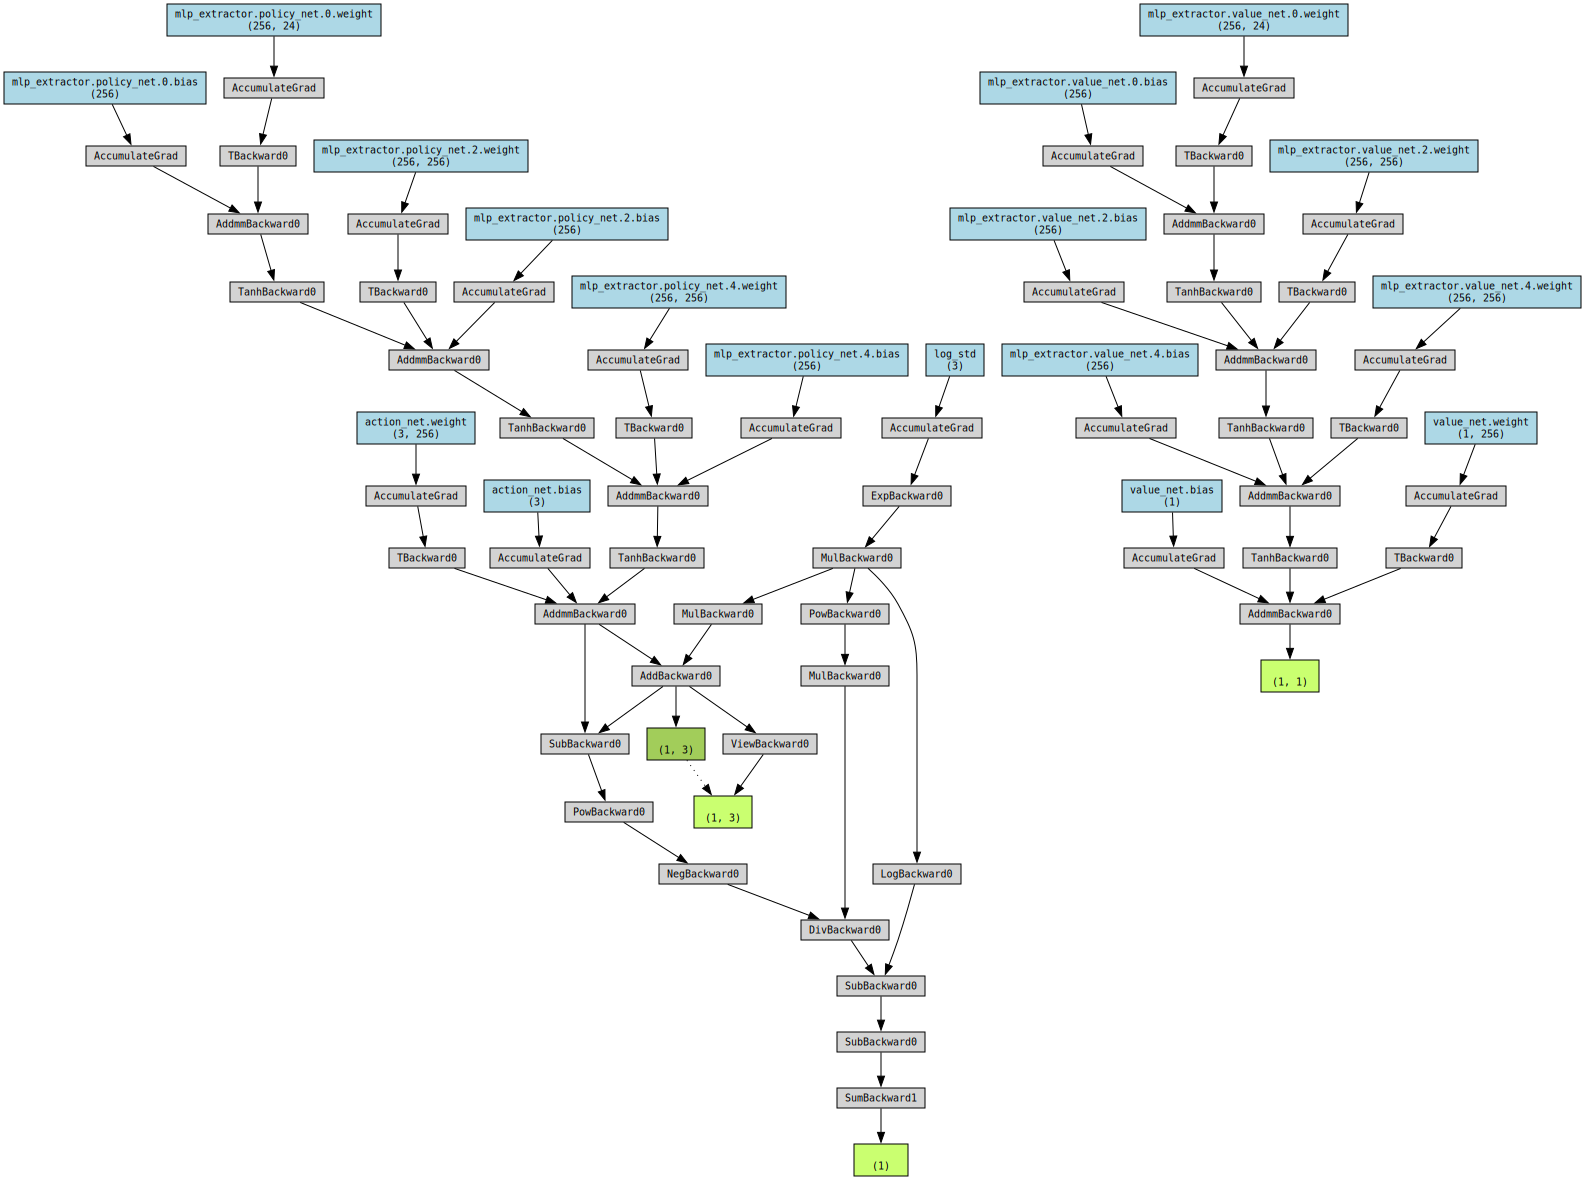

Logging to ./tensorboard/ppo_push/PPO_10
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 44.4     |
|    ep_rew_mean     | -44.3    |
|    success_rate    | 0.133    |
| time/              |          |
|    fps             | 47       |
|    iterations      | 1        |
|    time_elapsed    | 42       |
|    total_timesteps | 2048     |
---------------------------------


In [ ]:
env = gym.make("FrankaPushSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
)

# PPO agent
model = PPO(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    learning_rate=0.001,
    batch_size=512,
    verbose=1,
    tensorboard_log="./tensorboard/ppo_push/",
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
model.learn(total_timesteps=200)
model.save('model/PPO_push.zip')

env.close()

Push Training(SAC)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


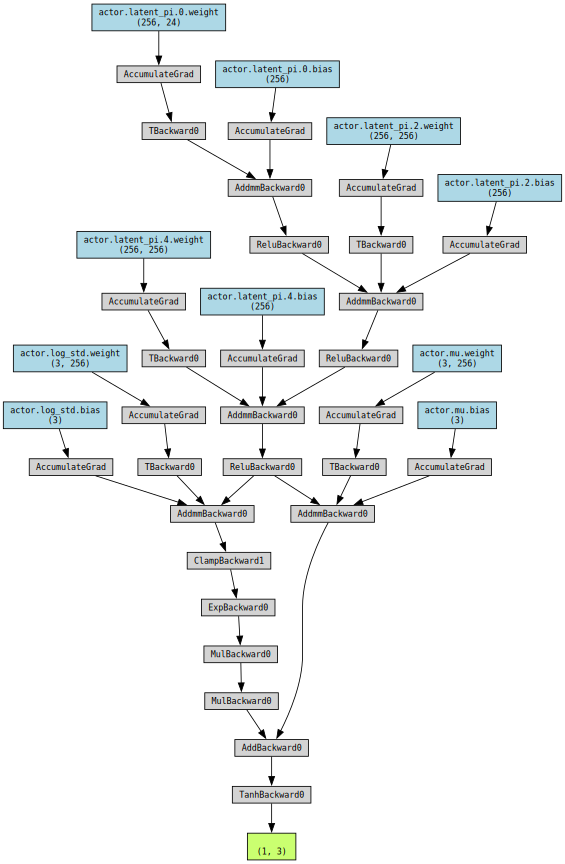

Logging to ./tensorboard/sac_push/SAC_4


d:\anaconda3\envs\rl_gpu\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_wrapper_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


Target Object Position: [0.53698191 0.09479239 0.01995554]
Initial Object Position: [0.6020726  0.07116451 0.01995638]
Final Object Position: [0.71371985 0.12461743 0.01995554]
Distance between Object and Target:0.17924
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 39       |
|    time_elapsed    | 5        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -8.72    |
|    critic_loss     | 0.134    |
|    ent_coef        | 0.907    |
|    ent_coef_loss   | -0.496   |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------


In [3]:
env = gym.make("FrankaPushSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Action noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
)

# HER strategy
goal_selection_strategy = 'future'
n_sampled_goal = 4

# SAC agent
model = SAC(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=n_sampled_goal,
        goal_selection_strategy=goal_selection_strategy,
    ),
    learning_rate=0.001,
    batch_size=512,
    buffer_size=int(1e6),
    tau=0.05,
    gamma=0.95,
    verbose=1,
    tensorboard_log="./tensorboard/sac_push/", 
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
callback = EpisodeInfoCallback(env)
model.learn(total_timesteps=200, callback=callback)
model.save('model/SAC_push.zip')

env.close()

Push Training(DDPG)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


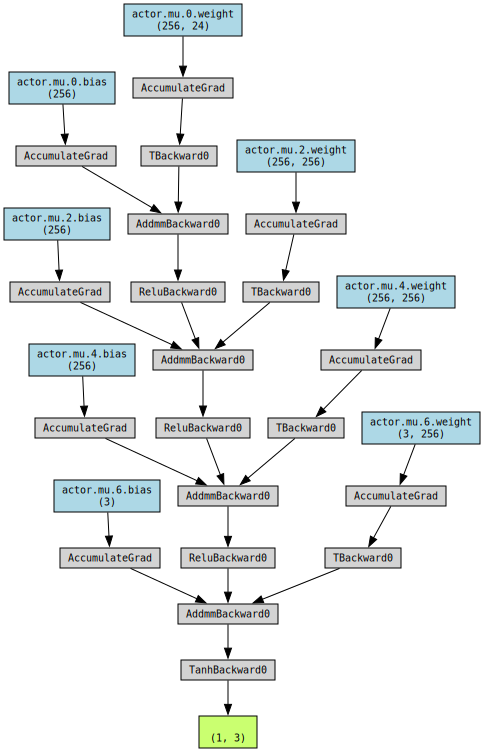

Logging to ./tensorboard/ddpg_push/DDPG_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.8     |
|    ep_rew_mean     | -37.5    |
|    success_rate    | 0.25     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 53       |
|    time_elapsed    | 2        |
|    total_timesteps | 151      |
| train/             |          |
|    actor_loss      | 0.483    |
|    critic_loss     | 0.0967   |
|    learning_rate   | 0.001    |
|    n_updates       | 50       |
---------------------------------
Target Object Position: [0.48576655 0.02345716 0.01995554]
Initial Object Position: [ 0.72972733 -0.09409807  0.01995638]
Final Object Position: [ 0.72972733 -0.09409807  0.01995638]
Distance between Object and Target:0.27081


In [4]:
env = gym.make("FrankaPushSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Action noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
)

# HER strategy
goal_selection_strategy = 'future'
n_sampled_goal = 4

# DDPG agent
model = DDPG(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=n_sampled_goal,
        goal_selection_strategy=goal_selection_strategy,
    ),
    learning_rate=0.001,
    batch_size=512,
    buffer_size=int(1e6), 
    tau=0.05,
    gamma=0.95,
    verbose=1,
    tensorboard_log="./tensorboard/ddpg_push/",
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
callback = EpisodeInfoCallback(env)
model.learn(total_timesteps=200, callback=callback)
model.save('model/DDPG_push.zip')

env.close()

Push Training(TQC)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


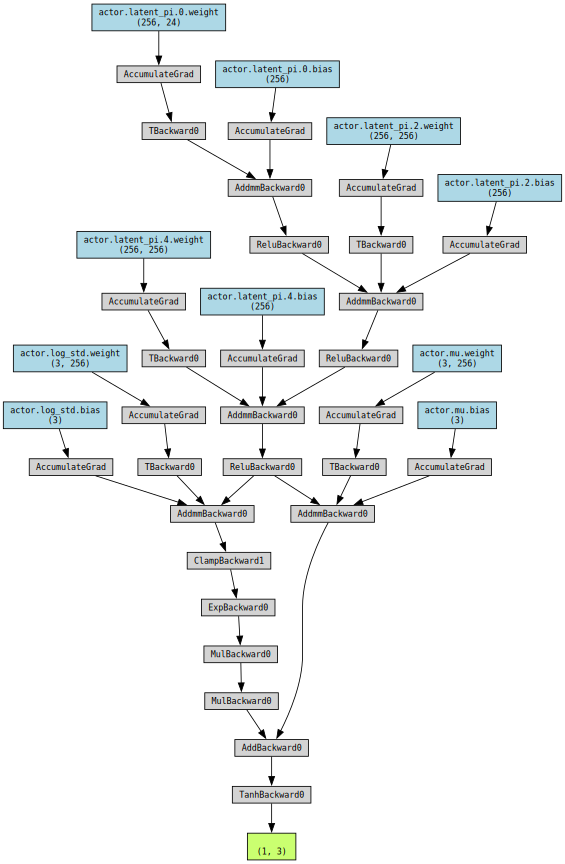

Logging to ./tensorboard/tqc_push/TQC_3
Target Object Position: [0.74282657 0.00589579 0.01995554]
Initial Object Position: [0.46158101 0.06212462 0.01995638]
Final Object Position: [ 0.69650193 -0.02530418  0.01995554]
Distance between Object and Target:0.05585
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 40       |
|    time_elapsed    | 4        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -7.9     |
|    critic_loss     | 0.0549   |
|    ent_coef        | 0.907    |
|    ent_coef_loss   | -0.493   |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------


In [5]:
env = gym.make("FrankaPushSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Action noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
    n_critics=2,
    n_quantiles=25,
)

# HER strategy
goal_selection_strategy = 'future'
n_sampled_goal = 4

# TQC agent
model = TQC(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=n_sampled_goal,
        goal_selection_strategy=goal_selection_strategy,
    ),
    learning_rate=0.001,
    batch_size=512,
    buffer_size=int(1e6),
    tau=0.05,
    gamma=0.95,
    verbose=1,
    tensorboard_log="./tensorboard/tqc_push/",
    
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
callback = EpisodeInfoCallback(env)
model.learn(total_timesteps=200, callback=callback)
model.save('model/TQC_push.zip')

env.close()

Pick Training(PPO)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


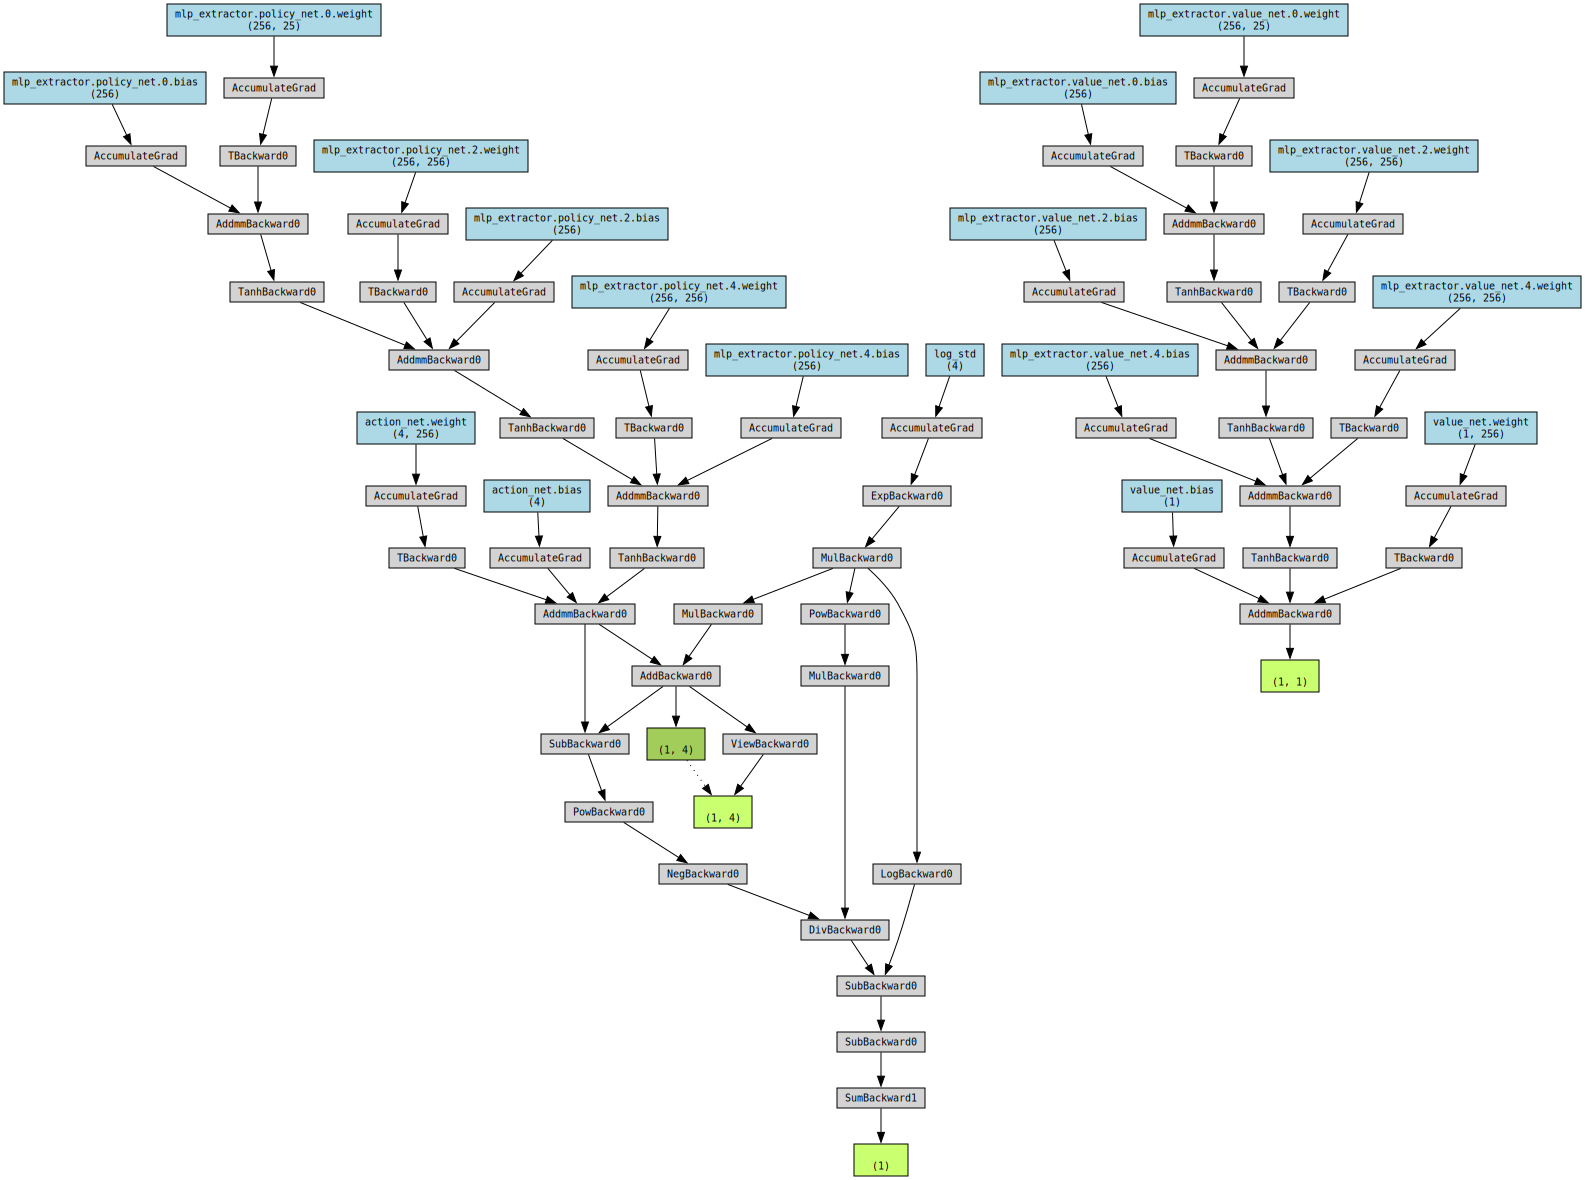

Logging to ./tensorboard/ppo_pick/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0.025    |
| time/              |          |
|    fps             | 47       |
|    iterations      | 1        |
|    time_elapsed    | 42       |
|    total_timesteps | 2048     |
---------------------------------


In [6]:
env = gym.make("FrankaPickSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
)

# PPO agent
model = PPO(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    learning_rate=0.001,
    batch_size=512,
    verbose=1,
    tensorboard_log="./tensorboard/ppo_pick/",
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
model.learn(total_timesteps=200)
model.save('model/PPO_pick.zip')

env.close()

Pick Training(SAC)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


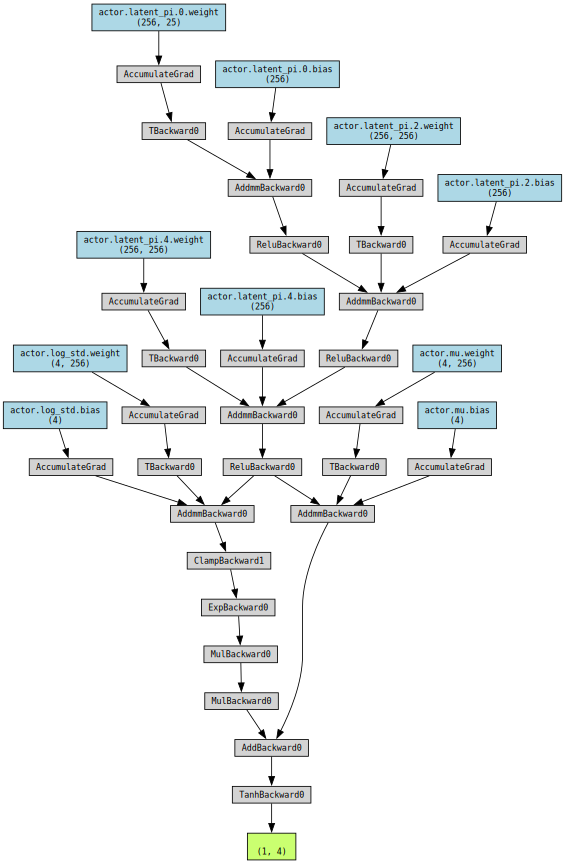

Logging to ./tensorboard/sac_pick/SAC_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.8     |
|    ep_rew_mean     | -37.5    |
|    success_rate    | 0.25     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 48       |
|    time_elapsed    | 3        |
|    total_timesteps | 151      |
| train/             |          |
|    actor_loss      | -7.77    |
|    critic_loss     | 0.329    |
|    ent_coef        | 0.952    |
|    ent_coef_loss   | -0.33    |
|    learning_rate   | 0.001    |
|    n_updates       | 50       |
---------------------------------
Target Object Position: [ 0.58401061 -0.02586498  0.07676998]
Initial Object Position: [0.56984012 0.1064014  0.01995638]
Final Object Position: [0.56983792 0.10639432 0.01995638]
Distance between Object and Target:0.14464


In [7]:
env = gym.make("FrankaPickSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Action noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
)

# HER strategy
goal_selection_strategy = 'future'
n_sampled_goal = 4

# SAC agent
model = SAC(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=n_sampled_goal,
        goal_selection_strategy=goal_selection_strategy,
    ),
    learning_rate=0.001,
    batch_size=512,
    buffer_size=int(1e6),
    tau=0.05,
    gamma=0.95,
    verbose=1,
    tensorboard_log="./tensorboard/sac_pick/",
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
callback = EpisodeInfoCallback(env)
model.learn(total_timesteps=200, callback=callback)
model.save('model/SAC_pick.zip')

env.close()

Pick Training(DDPG)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


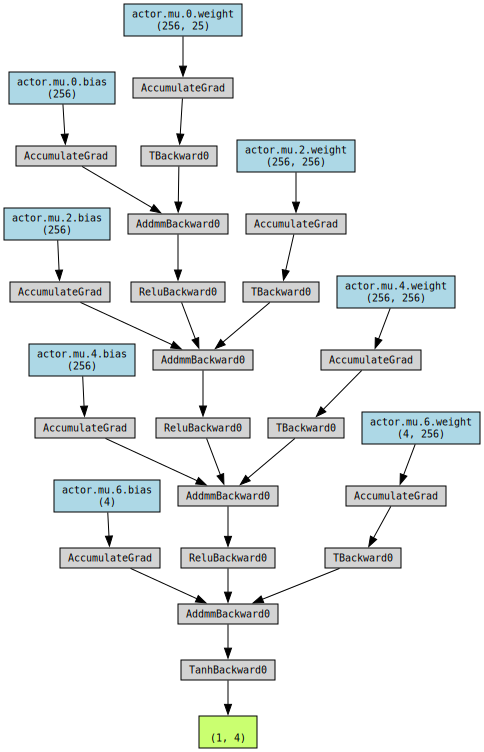

Logging to ./tensorboard/ddpg_pick/DDPG_2
Target Object Position: [ 0.45574682 -0.07999102  0.01995558]
Initial Object Position: [0.63106114 0.01659688 0.01995638]
Final Object Position: [0.70616374 0.04118134 0.01995558]
Distance between Object and Target:0.27819
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 41       |
|    time_elapsed    | 4        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | 0.703    |
|    critic_loss     | 0.041    |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------


In [8]:
env = gym.make("FrankaPickSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Action noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
)

# HER strategy
goal_selection_strategy = 'future'
n_sampled_goal = 4

# DDPG agent
model = DDPG(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=n_sampled_goal,
        goal_selection_strategy=goal_selection_strategy,
    ),
    learning_rate=0.001,
    batch_size=512,
    buffer_size=int(1e6), 
    tau=0.05,
    gamma=0.95,
    verbose=1,
    tensorboard_log="./tensorboard/ddpg_pick/",
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
callback = EpisodeInfoCallback(env)
model.learn(total_timesteps=200, callback=callback)
model.save('model/DDPG_pick.zip')

env.close()

Pick Training(TQC)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


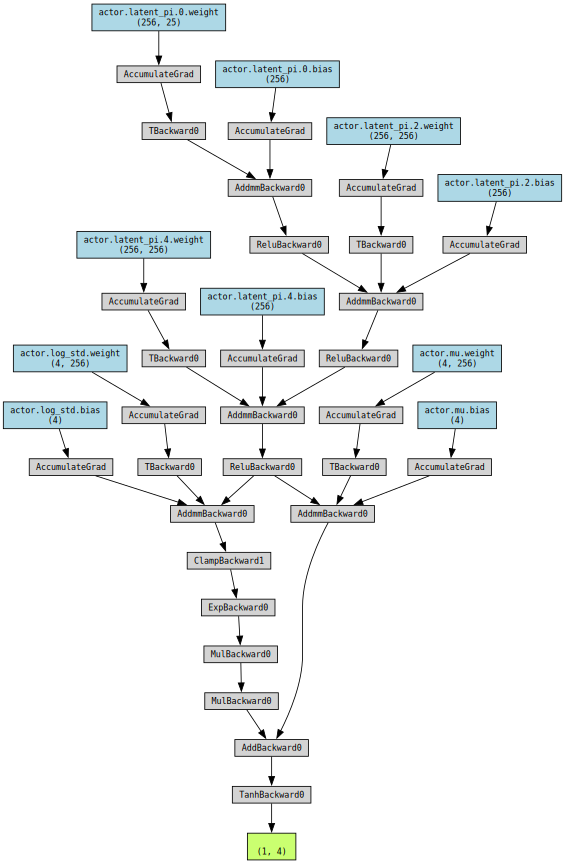

Logging to ./tensorboard/tqc_pick/TQC_2
Target Object Position: [ 0.72638841 -0.10379486  0.16196207]
Initial Object Position: [0.48691534 0.14104879 0.01995638]
Final Object Position: [0.71448773 0.09700534 0.01995558]
Distance between Object and Target:0.24623
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 36       |
|    time_elapsed    | 5        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -10.9    |
|    critic_loss     | 0.0437   |
|    ent_coef        | 0.907    |
|    ent_coef_loss   | -0.658   |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------


In [9]:
env = gym.make("FrankaPickSparse", render_mode="human")

# Dimension of the action space
n_actions = env.action_space.shape[-1]

# Action noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

# Network architecture and optimizer parameters
policy_kwargs = dict(
    net_arch=[256, 256, 256],
    optimizer_class=th.optim.Adam,
    n_critics=2,
    n_quantiles=25,
)

# HER strategy
goal_selection_strategy = 'future'
n_sampled_goal = 4

# TQC agent
model = TQC(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=n_sampled_goal,
        goal_selection_strategy=goal_selection_strategy,
    ),
    learning_rate=0.001,
    batch_size=512,
    buffer_size=int(1e6),
    tau=0.05,
    gamma=0.95,
    verbose=1,
    tensorboard_log="./tensorboard/tqc_pick/",
)

# Visualize the network
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model.policy.to(device)
obs, _ = env.reset()
sample_input = {key: th.tensor(value).float().unsqueeze(0).to(device) for key, value in obs.items()}
output = model.policy(sample_input)
dot = make_dot(output, params=dict(model.policy.named_parameters()))
display(dot)

# Start training
callback = EpisodeInfoCallback(env)
model.learn(total_timesteps=200, callback=callback)
model.save('model/TQC_pick.zip')

env.close()